In [2]:
"""
Get the general graph of a given model

Algorithm :
Get model & dicts
Get circuit fct
aggregate graphs over dataset
test this graph on dataset

TODO : get circuit fct is wrong from marks
TODO : test graph is wrong from marks (but eh, it will yield better results as we will
       have essentially the whole graph, but hush, don't say it ! :o)
"""

try:
    import google.colab
    IN_COLAB = True
    from tqdm.notebook import tqdm, trange

    from google.colab import drive
    drive.mount("/content/gdrive", force_remount=True)
    %cd /content/gdrive/MyDrive/feature-circuits
    %pip install -r requirements.txt
    !git submodule update --init
except:
    IN_COLAB = False
    from tqdm import tqdm, trange

import os
import gc

from transformers import logging
logging.set_verbosity_error()

import torch
from nnsight import LanguageModel
from datasets import load_dataset

from dictionary_learning import AutoEncoder
from utils import SparseAct
from buffer import TokenBuffer
from circuit import get_circuit, save_circuit, load_circuit
from ablation import run_with_ablations

DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print("DEVICE :", DEVICE)

print("IN_COLAB :", IN_COLAB)

DEVICE : cuda:0
IN_COLAB : False


First step : generate the graph

compute the circuit for random examples from wikipedia, and aggregate the results

TODO : move tokensbuffer in a separate file

In [3]:
pythia70m = LanguageModel(
    "EleutherAI/pythia-70m-deduped",
    device_map=DEVICE,
    dispatch=True,
)

pythia70m_embed = pythia70m.gpt_neox.embed_in

pythia70m_resids= []
pythia70m_attns = []
pythia70m_mlps = []
for layer in range(len(pythia70m.gpt_neox.layers)):
    pythia70m_resids.append(pythia70m.gpt_neox.layers[layer])
    pythia70m_attns.append(pythia70m.gpt_neox.layers[layer].attention)
    pythia70m_mlps.append(pythia70m.gpt_neox.layers[layer].mlp)

c:\Users\ConnardMcGregoire\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
dataset = load_dataset(
    "wikipedia",
    language="en",
    date="20240401",
    split="train",
    streaming=True,
    trust_remote_code=True
).shuffle()
dataset = iter(dataset)

In [5]:
buffer = TokenBuffer(
    dataset,
    pythia70m,
    n_ctxs=10,
    ctx_len=16,
    load_buffer_batch_size=10,
    return_batch_size=10,
    device=DEVICE,
    max_number_of_yields=2**20,
    discard_bos=True
)

In [6]:
if IN_COLAB:
    base = "/content/gdrive/MyDrive/feature-circuits/"
else:
    #base = "C:/Users/Grégoire/Documents/ENS/stages/AttentionGraph/Marks/feature-circuits/"
    base = 'C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/'
path = base + "dictionary_learning/dictionaires/pythia-70m-deduped/"

if not os.path.exists(path):
    if IN_COLAB:
        # go to base / dictionary_learning :
        %cd /content/gdrive/MyDrive/feature-circuits/dictionary_learning
        !apt-get update
        !apt-get install dos2unix
        !dos2unix pretrained_dictionary_downloader.sh
        !chmod +x pretrained_dictionary_downloader.sh
        !./pretrained_dictionary_downloader.sh
        %cd /content/gdrive/MyDrive/feature-circuits
    else:
        #%cd C:/Users/Grégoire/Documents/ENS/stages/AttentionGraph/Marks/feature-circuits/dictionary_learning
        %cd C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/dictionary_learning
        %run ./pretrained_dictionary_downloader.sh
        #%cd C:/Users/Grégoire/Documents/ENS/stages/AttentionGraph/Marks/feature-circuits
        %cd C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits

dictionaries = {}

d_model = 512
dict_size = 32768

ae = AutoEncoder(d_model, dict_size).to(DEVICE)
ae.load_state_dict(torch.load(path + f"embed/ae.pt", map_location=DEVICE))
dictionaries[pythia70m_embed] = ae


for layer in range(len(pythia70m.gpt_neox.layers)):
    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(torch.load(path + f"resid_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_resids[layer]] = ae

    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(torch.load(path + f"attn_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_attns[layer]] = ae

    ae = AutoEncoder(d_model, dict_size).to(DEVICE)
    ae.load_state_dict(torch.load(path + f"mlp_out_layer{layer}/ae.pt", map_location=DEVICE))
    dictionaries[pythia70m_mlps[layer]] = ae

In [7]:
def metric_fn_v1(model, trg=None):
    """
    default : return the logit
    """
    if trg is None:
        raise ValueError("trg must be provided")
    logits = model.embed_out.output[:,-1,:]
    return logits[torch.arange(trg.numel()), trg]
    
def metric_fn_v2(model, trg=None):
    """
    default : return the logit
    """
    if trg is None:
        raise ValueError("trg must be provided")
    return model.embed_out.output[torch.arange(trg[0].numel()), trg[0], trg[1]]

def metric_fn_v3(model, trg=None):
    """
    Return -log probability for the expected target.

    trg : torch.Tensor, contains idxs of the target tokens (between 0 and d_vocab_out)

    /!\ here we assume that all last tokens are indeed in the last position (if padding, it must happen in front of the sequence, not after)
    """
    if trg is None:
        raise ValueError("trg must be provided")
    logits = model.embed_out.output[:,-1,:]
    return (
         -1 * torch.gather(
             torch.nn.functional.log_softmax(model.embed_out.output[:,-1,:], dim=-1),
             dim=-1, index=trg.view(-1, 1)
         ).squeeze(-1)
    )

TODO : if multiple GPUS, use nn.DataParallel and compute batches of length num_gpus. Each GPU will compute one input. Maybe DistributedDataParallel is better.

Or : launch N instances of the code that work independently on random inputs, each on their own GPU, save the circuits in a file and then process 0 is in charge of aggregating the results. If torch provide multiprocessing communications, this can be done without storing to the disc. Then process 0 sends to all the others the final circuits, they all test it and aggregate the results.

In [9]:
tot_circuit = None
i = 0
max_loop = -1
edge_threshold = 0.01
node_threshold = 0.1

In [7]:
for tokens, trg_idx, trg in tqdm(buffer):
    if i >= max_loop:
        break
    i += 1
    circuit = get_circuit(
        tokens,
        None,
        model=pythia70m,
        embed=pythia70m_embed,
        attns=pythia70m_attns,
        mlps=pythia70m_mlps,
        resids=pythia70m_resids,
        dictionaries=dictionaries,
        metric_fn=metric_fn_v2,
        metric_kwargs={"trg": (trg_idx, trg)},
        node_threshold=node_threshold,
        edge_threshold=edge_threshold
    )
    if tot_circuit is None:
        tot_circuit = circuit
    else:
        for k, v in circuit[0].items():
            if v is not None:
                tot_circuit[0][k] += v
        for ku, vu in circuit[1].items():
            for kd, vd in vu.items():
                if vd is not None:
                    tot_circuit[1][ku][kd] += vd
    
    if i % 16 == 0:
        save_circuit(
            "C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/circuits/",
            tot_circuit[0],
            tot_circuit[1],
            "wikipedia3",
            "pythia_70m_deduped",
            node_threshold,
            edge_threshold,
            i
        )
    
    del circuit
    gc.collect()

0it [00:00, ?it/s]

Extracting content from https://dumps.wikimedia.org/enwiki/20240401/enwiki-20240401-pages-articles-multistream23.xml-p49288942p50564553.bz2


0it [00:26, ?it/s]


TODO : test general circuit on IOI task and on general task. Plot avg degree of nodes when pruning the graph for reach and co reach for node threshold / node proportion for graph build upon 1 2 4 8 [i * 16]_i=1^10

In [8]:
submod_names = {
    pythia70m.gpt_neox.embed_in : 'embed'
}
for i in range(len(pythia70m.gpt_neox.layers)):
    submod_names[pythia70m.gpt_neox.layers[i].attention] = f'attn_{i}'
    submod_names[pythia70m.gpt_neox.layers[i].mlp] = f'mlp_{i}'
    submod_names[pythia70m.gpt_neox.layers[i]] = f'resid_{i}'

In [11]:
n = 144

circuit = load_circuit(
    "C:/Users/ConnardMcGregoire/Documents/MI_Internship/feature-circuits/circuits/",
    "wikipedia3",
    "pythia_70m_deduped",
    node_threshold,
    edge_threshold,
    n
)

In [10]:
start_at_layer = 2
submodules = [pythia70m_embed] if start_at_layer == 0 else []
for i in range(start_at_layer, len(pythia70m.gpt_neox.layers)):
    submodules.append(pythia70m_attns[i])
    submodules.append(pythia70m_mlps[i])
    submodules.append(pythia70m_resids[i])

feat_dicts = dictionaries

In [13]:
# use mean ablation


import importlib
import ablation
importlib.reload(ablation)
from ablation import run_with_ablations

ablation_fn = lambda x: x.mean(dim=0).expand_as(x)

# get m(C) for the circuit obtained by thresholding nodes with the given threshold
def get_fcs(
    model,
    circuit,
    clean,
    trg_idx,
    trg,
    submodules,
    dictionaries,
    ablation_fn,
    thresholds,
    handle_errors = 'default', # also 'remove' or 'resid_only'
):
    clean_inputs = clean

    # def metric_fn(model):
    #     return (
    #         - t.gather(model.embed_out.output[:,-1,:], dim=-1, index=patch_answer_idxs.view(-1, 1)).squeeze(-1) + \
    #         t.gather(model.embed_out.output[:,-1,:], dim=-1, index=clean_answer_idxs.view(-1, 1)).squeeze(-1)
    #     )
    def metric_fn(model):
        return metric_fn_v2(model, trg=(trg_idx, trg))
    
    circuit = circuit[0]

    with torch.no_grad():
        out = {}

        # get F(M)
        with model.trace(clean_inputs):
            metric = metric_fn(model).save()
        fm = metric.value.mean().item()

        out['fm'] = fm

        # get m(∅)
        fempty = run_with_ablations(
            clean_inputs,
            None,
            model,
            submodules,
            dictionaries,
            nodes = {
                submod : SparseAct(
                    act=torch.zeros(dict_size, dtype=torch.bool), 
                    resc=torch.zeros(1, dtype=torch.bool)).to(DEVICE)
                for submod in submodules
            },
            metric_fn=metric_fn,
            ablation_fn=ablation_fn,
        ).mean().item()
        out['fempty'] = fempty

        for threshold in thresholds:
            out[threshold] = {}
            nodes = {
                submod : circuit[submod_names[submod]].abs() > threshold for submod in submodules
            }

            if handle_errors == 'remove':
                for k in nodes: nodes[k].resc = torch.zeros_like(nodes[k].resc, dtype=torch.bool)
            elif handle_errors == 'resid_only':
                for k in nodes:
                    if k not in model.gpt_neox.layers: nodes[k].resc = torch.zeros_like(nodes[k].resc, dtype=torch.bool)

            n_nodes = sum([n.act.sum() + n.resc.sum() for n in nodes.values()]).item()
            out[threshold]['n_nodes'] = n_nodes
            
            out[threshold]['fc'] = run_with_ablations(
                clean_inputs,
                None,
                model,
                submodules,
                dictionaries,
                nodes=nodes,
                metric_fn=metric_fn,
                ablation_fn=ablation_fn,
            ).mean().item()
            out[threshold]['fccomp'] = run_with_ablations(
                clean_inputs,
                None,
                model,
                submodules,
                dictionaries,
                nodes=nodes,
                metric_fn=metric_fn,
                ablation_fn=ablation_fn,
                complement=True
            ).mean().item()
            out[threshold]['faithfulness'] = (out[threshold]['fc'] - fempty) / (fm - fempty)
            out[threshold]['completeness'] = (out[threshold]['fccomp'] - fempty) / (fm - fempty)
    
    print("the end")
    return out

In [14]:
i = 0
max_loop = 1

for tokens, trg_idx, trg in tqdm(buffer):
    if i >= max_loop:
        break
    i += 1
    #thresholds = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032, 0.064, 0.128, 0.256, 0.512]
    thresholds = torch.logspace(-6, 2, 20, 10).tolist()
    outs = {
        'features' :
            get_fcs(
                pythia70m,
                circuit,
                tokens,
                trg_idx,
                trg,
                submodules,
                feat_dicts,
                ablation_fn=ablation_fn,
                thresholds = thresholds,
            ),
        'features_wo_errs' :
            get_fcs(
                pythia70m,
                circuit,
                tokens,
                trg_idx,
                trg,
                submodules,
                feat_dicts,
                ablation_fn=ablation_fn,
                thresholds = thresholds,
                handle_errors='remove'
            ),
        'features_wo_some_errs' :
            get_fcs(
                pythia70m,
                circuit,
                tokens,
                trg_idx,
                trg,
                submodules,
                feat_dicts,
                ablation_fn=ablation_fn,
                thresholds = thresholds,
                handle_errors='resid_only'
            )
    }

0it [00:00, ?it/s]

the end
the end


1it [02:03, 123.75s/it]

the end


In [19]:
import plotly.graph_objects as go
from scipy import interpolate
import math

# plot faithfulness results
fig = go.Figure()

colors = {
    'features' : 'blue',
    'features_wo_errs' : 'red',
    'features_wo_some_errs' : 'green',
    'neurons' : 'purple',
    # 'random_features' : 'black'
}

y_min = 0
y_max = 1
for setting, subouts in outs.items():
    x_min = max([min(subouts[t]['n_nodes'] for t in thresholds)]) + 1
    x_max = min([max(subouts[t]['n_nodes'] for t in thresholds)]) - 1
    fs = {
        "ioi" : interpolate.interp1d([subouts[t]['n_nodes'] for t in thresholds], [subouts[t]['faithfulness'] for t in thresholds])
    }
    xs = torch.logspace(math.log10(x_min), math.log10(x_max), 100, 10).tolist()

    fig.add_trace(go.Scatter(
        x = [subouts[t]['n_nodes'] for t in thresholds],
        y = [subouts[t]['faithfulness'] for t in thresholds],
        mode='lines', line=dict(color=colors[setting]), opacity=0.17, showlegend=False
    ))

    y_min = min(y_min, min([subouts[t]['faithfulness'] for t in thresholds]))
    y_max = max(y_max, max([subouts[t]['faithfulness'] for t in thresholds]))

    fig.add_trace(go.Scatter(
        x=xs,
        y=[ sum([f(x) for f in fs.values()]) / len(fs) for x in xs ],
        mode='lines', line=dict(color=colors[setting]), name=setting
    ))

fig.update_xaxes(type="log", range=[math.log10(x_min), math.log10(x_max)])
fig.update_yaxes(range=[y_min, min(y_max, 2)])

fig.update_layout(
    xaxis_title='Nodes',
    yaxis_title='Faithfulness',
    width=800,
    height=375,
    # set white background color
    plot_bgcolor='rgba(0,0,0,0)',
    # add grey gridlines
    yaxis=dict(gridcolor='rgb(200,200,200)',mirror=True,ticks='outside',showline=True),
    xaxis=dict(gridcolor='rgb(200,200,200)', mirror=True, ticks='outside', showline=True),

)

# fig.show()
fig.write_image('faithfulness.pdf')

In [29]:
import evaluation
import importlib
importlib.reload(evaluation)

digraph = evaluation.to_Digraph(circuit)
digraph_without_errors = evaluation.to_Digraph(circuit, discard_res=True)

resid_5 y
torch.Size([1, 3339])
torch.Size([32769])
mlp_5 resid_5
torch.Size([2, 140741])
torch.Size([32769, 32769])
attn_5 resid_5
torch.Size([2, 204123])
torch.Size([32769, 32769])
resid_4 mlp_5
torch.Size([2, 64859])
torch.Size([32769, 32769])
resid_4 attn_5
torch.Size([2, 135503])
torch.Size([32769, 32769])
resid_4 resid_5
torch.Size([2, 546771])
torch.Size([32769, 32769])
mlp_4 resid_4
torch.Size([2, 205212])
torch.Size([32769, 32769])
attn_4 resid_4
torch.Size([2, 235176])
torch.Size([32769, 32769])
resid_3 mlp_4
torch.Size([2, 85006])
torch.Size([32769, 32769])
resid_3 attn_4
torch.Size([2, 105515])
torch.Size([32769, 32769])
resid_3 resid_4
torch.Size([2, 719352])
torch.Size([32769, 32769])
mlp_3 resid_3
torch.Size([2, 373517])
torch.Size([32769, 32769])
attn_3 resid_3
torch.Size([2, 326315])
torch.Size([32769, 32769])
resid_2 mlp_3
torch.Size([2, 188920])
torch.Size([32769, 32769])
resid_2 attn_3
torch.Size([2, 300318])
torch.Size([32769, 32769])
resid_2 resid_3
torch.Size([2,

In [59]:
# save the nx digraphs
import networkx as nx
import pickle
import os

if not os.path.exists('circuits/nx'):
    os.makedirs('circuits/nx')
with open('circuits/nx/digraph.pkl', 'wb') as f:
    pickle.dump(digraph, f)

with open('circuits/nx/digraph_we.pkl', 'wb') as f:
    pickle.dump(digraph_without_errors, f)

In [64]:
modules = set()
for node in digraph.nodes:
    if 'embed' in node:
        print(node)
    module = node.split('_')[0]
    modules.add(module)

print(modules)

embed_32076
embed_32768
embed_19957
embed_16189
embed_386
embed_404
embed_651
embed_1291
embed_2118
embed_2439
embed_2627
embed_3104
embed_4019
embed_4070
embed_4891
embed_4950
embed_5725
embed_6928
embed_8372
embed_8493
embed_8965
embed_9711
embed_9756
embed_10379
embed_10513
embed_11147
embed_11228
embed_11971
embed_12705
embed_13755
embed_13775
embed_14344
embed_14429
embed_14649
embed_16053
embed_16073
embed_16243
embed_17233
embed_17847
embed_19236
embed_19582
embed_19820
embed_20185
embed_22107
embed_22250
embed_23343
embed_23547
embed_23668
embed_24088
embed_29305
embed_29545
embed_30093
embed_30162
embed_30212
embed_31377
embed_32408
embed_1240
embed_5982
embed_287
embed_1388
embed_3107
embed_3124
embed_4495
embed_4776
embed_6650
embed_6860
embed_6893
embed_6948
embed_7081
embed_7432
embed_8208
embed_8661
embed_10714
embed_11766
embed_12002
embed_12952
embed_13070
embed_13117
embed_13615
embed_15722
embed_16737
embed_17759
embed_18478
embed_19827
embed_20886
embed_22118
embed_2

In [66]:
pruned = evaluation.prune(digraph)
pruned_without_errors = evaluation.prune(digraph_without_errors)

embed_32076
embed_32768
embed_19957
embed_16189
embed_386
embed_404
embed_651
embed_1291
embed_2118
embed_2439
embed_2627
embed_3104
embed_4019
embed_4070
embed_4891
embed_4950
embed_5725
embed_6928
embed_8372
embed_8493
embed_8965
embed_9711
embed_9756
embed_10379
embed_10513
embed_11147
embed_11228
embed_11971
embed_12705
embed_13755
embed_13775
embed_14344
embed_14429
embed_14649
embed_16053
embed_16073
embed_16243
embed_17233
embed_17847
embed_19236
embed_19582
embed_19820
embed_20185
embed_22107
embed_22250
embed_23343
embed_23547
embed_23668
embed_24088
embed_29305
embed_29545
embed_30093
embed_30162
embed_30212
embed_31377
embed_32408
embed_1240
embed_5982
embed_287
embed_1388
embed_3107
embed_3124
embed_4495
embed_4776
embed_6650
embed_6860
embed_6893
embed_6948
embed_7081
embed_7432
embed_8208
embed_8661
embed_10714
embed_11766
embed_12002
embed_12952
embed_13070
embed_13117
embed_13615
embed_15722
embed_16737
embed_17759
embed_18478
embed_19827
embed_20886
embed_22118
embed_2

In [67]:
importlib.reload(evaluation)

sparsity = evaluation.sparsity(digraph)
sparsity_we = evaluation.sparsity(digraph_without_errors)
sparsity_pruned = evaluation.sparsity(pruned)
sparsity_pruned_we = evaluation.sparsity(pruned_without_errors)

print('Stats of the original graph :')
print(sparsity)
print('\n\nStats of the original graph without errors :')
print(sparsity_we)
print('\n\nStats of the pruned graph :')
print(sparsity_pruned)
print('\n\nStats of the pruned graph without errors :')
print(sparsity_pruned_we)

Stats of the original graph :
{'nedges': 9843940, 'nnodes': 103030, 'avgdegree': 191.0888090847326, 'connected_components': 2395, 'density': 0.0009273544782766629, 'degree_distribution': [0, 5449, 2504, 2159, 1969, 1643, 1646, 1421, 1294, 1345, 1288, 1179, 1495, 1364, 1624, 1279, 1296, 1099, 1273, 1014, 1183, 1098, 1042, 1088, 831, 970, 870, 882, 848, 923, 762, 847, 734, 726, 621, 748, 609, 564, 605, 495, 565, 509, 609, 591, 488, 556, 626, 523, 459, 528, 533, 476, 481, 463, 447, 447, 448, 449, 399, 367, 434, 438, 334, 397, 425, 428, 408, 408, 348, 348, 336, 329, 325, 313, 391, 374, 305, 344, 273, 270, 317, 369, 293, 273, 341, 272, 242, 258, 276, 220, 284, 248, 263, 287, 238, 214, 232, 234, 236, 262, 230, 215, 220, 197, 208, 198, 181, 217, 194, 204, 158, 193, 202, 157, 160, 235, 152, 162, 153, 181, 160, 160, 170, 139, 165, 179, 156, 143, 143, 138, 137, 133, 146, 131, 159, 149, 126, 136, 134, 143, 128, 116, 131, 145, 109, 138, 132, 122, 108, 120, 105, 122, 125, 117, 95, 100, 111, 89, 107

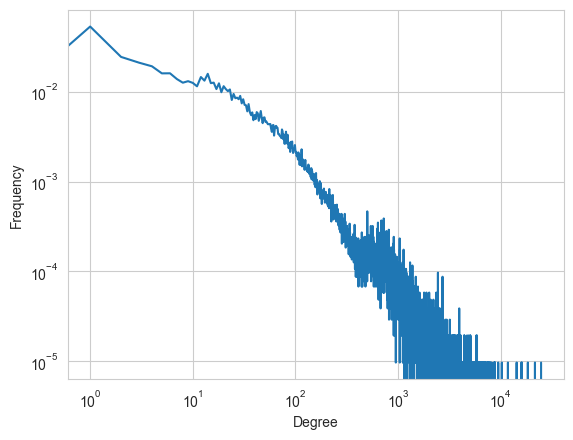

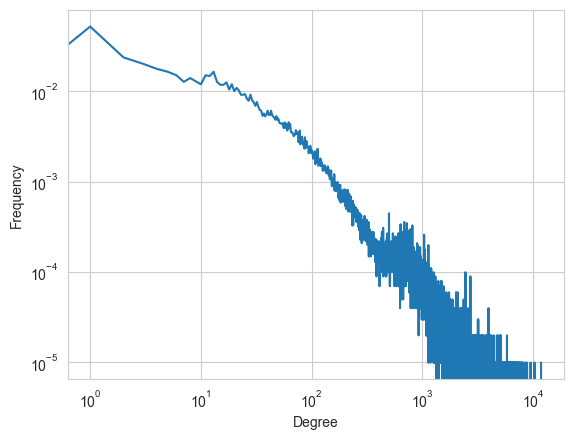

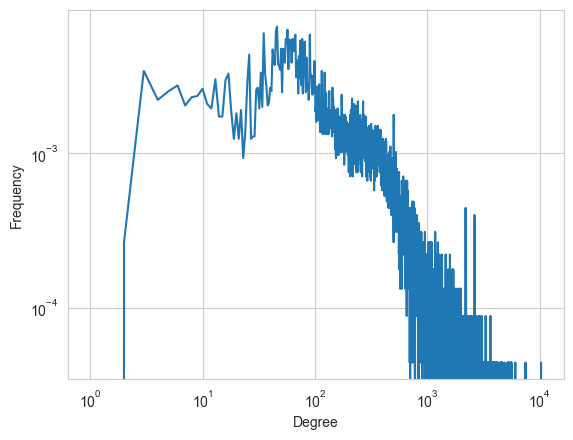

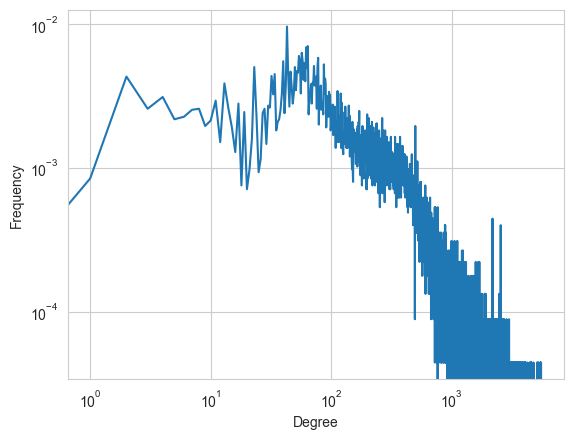

In [55]:
degree_distribution = sparsity['degree_distribution']
degree_distribution = [e / sparsity['nnodes'] for e in degree_distribution]

dd_we = sparsity_we['degree_distribution']
dd_we = [e / sparsity_we['nnodes'] for e in dd_we]

dd_pruned = sparsity_pruned['degree_distribution']
dd_pruned = [e / sparsity_pruned['nnodes'] for e in dd_pruned]

dd_pruned_we = sparsity_pruned_we['degree_distribution']
dd_pruned_we = [e / sparsity_pruned_we['nnodes'] for e in dd_pruned_we]

from matplotlib import pyplot as plt

def plot_degree_distribution(degree_distribution, title='Degree distribution'):
    plt.plot(degree_distribution)
    plt.xlabel('Degree')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.xscale('log')
    plt.show()

plot_degree_distribution(degree_distribution, 'Degree distribution')
plot_degree_distribution(dd_we, 'Degree distribution without errors nodes')
plot_degree_distribution(dd_pruned, 'Pruned degree distribution')
plot_degree_distribution(dd_pruned_we, 'Pruned degree distribution without errors nodes')

In [90]:
import numpy as np

r = np.random.rand(100)
r = r > 0.5

print("number of True :", r.sum())

number of True : 40
